### QC performance of the trained de-speckling conditional diffusion model on SAR images

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions.gamma import Gamma
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel
from einops import rearrange
from tqdm.notebook import tqdm

from sar_denoise.DDPMSpecklePipeline import DDPMSpecklePipeline
from sar_denoise.dataset_transforms import make_transform_images 

In [3]:
unet = UNet2DModel.from_pretrained("/data/diffden/exp_speckle_1_output/unet")
# use torch.compile on this

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# TODO can just load pipeline instead of loading unet?
pipeline = DDPMSpecklePipeline(
    unet=unet,
    scheduler=noise_scheduler,
).to("cuda")

device = pipeline.device

In [6]:
# This prints the number of parameters in unconditional diffusion model:
print(sum(p.numel() for p in unet.parameters()))

28445505


In [4]:
# Preprocessing the datasets and DataLoaders creation.
augmentations = transforms.Compose(
    [
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # probably wrong scaling for SAR
    ]
)

def transform_images(examples):
    images = [augmentations(image.convert("L")) for image in examples["image"]]
    return {"input": images}


In [5]:
full_dataset = load_dataset("ReginaFoley/sar_tile_512")
full_dataset.set_transform(transform_images)

image_indices = (np.r_[:16] * 17 + 31).astype(int).tolist()
dataset = torch.utils.data.Subset(full_dataset["train"], image_indices)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [6]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def plot_image_batch(images):
   # note: it might be better to normalize each image in the batch individually
   images_np = (normalize_image(images) * 255).float().round().cpu().squeeze(1).numpy().astype(np.uint8) 

   fig, axs = plt.subplots(4, 4, figsize=(20, 20))
   for i, ax in enumerate(axs.flat):
       ax.imshow(images_np[i], cmap="gray")
       ax.axis("off")

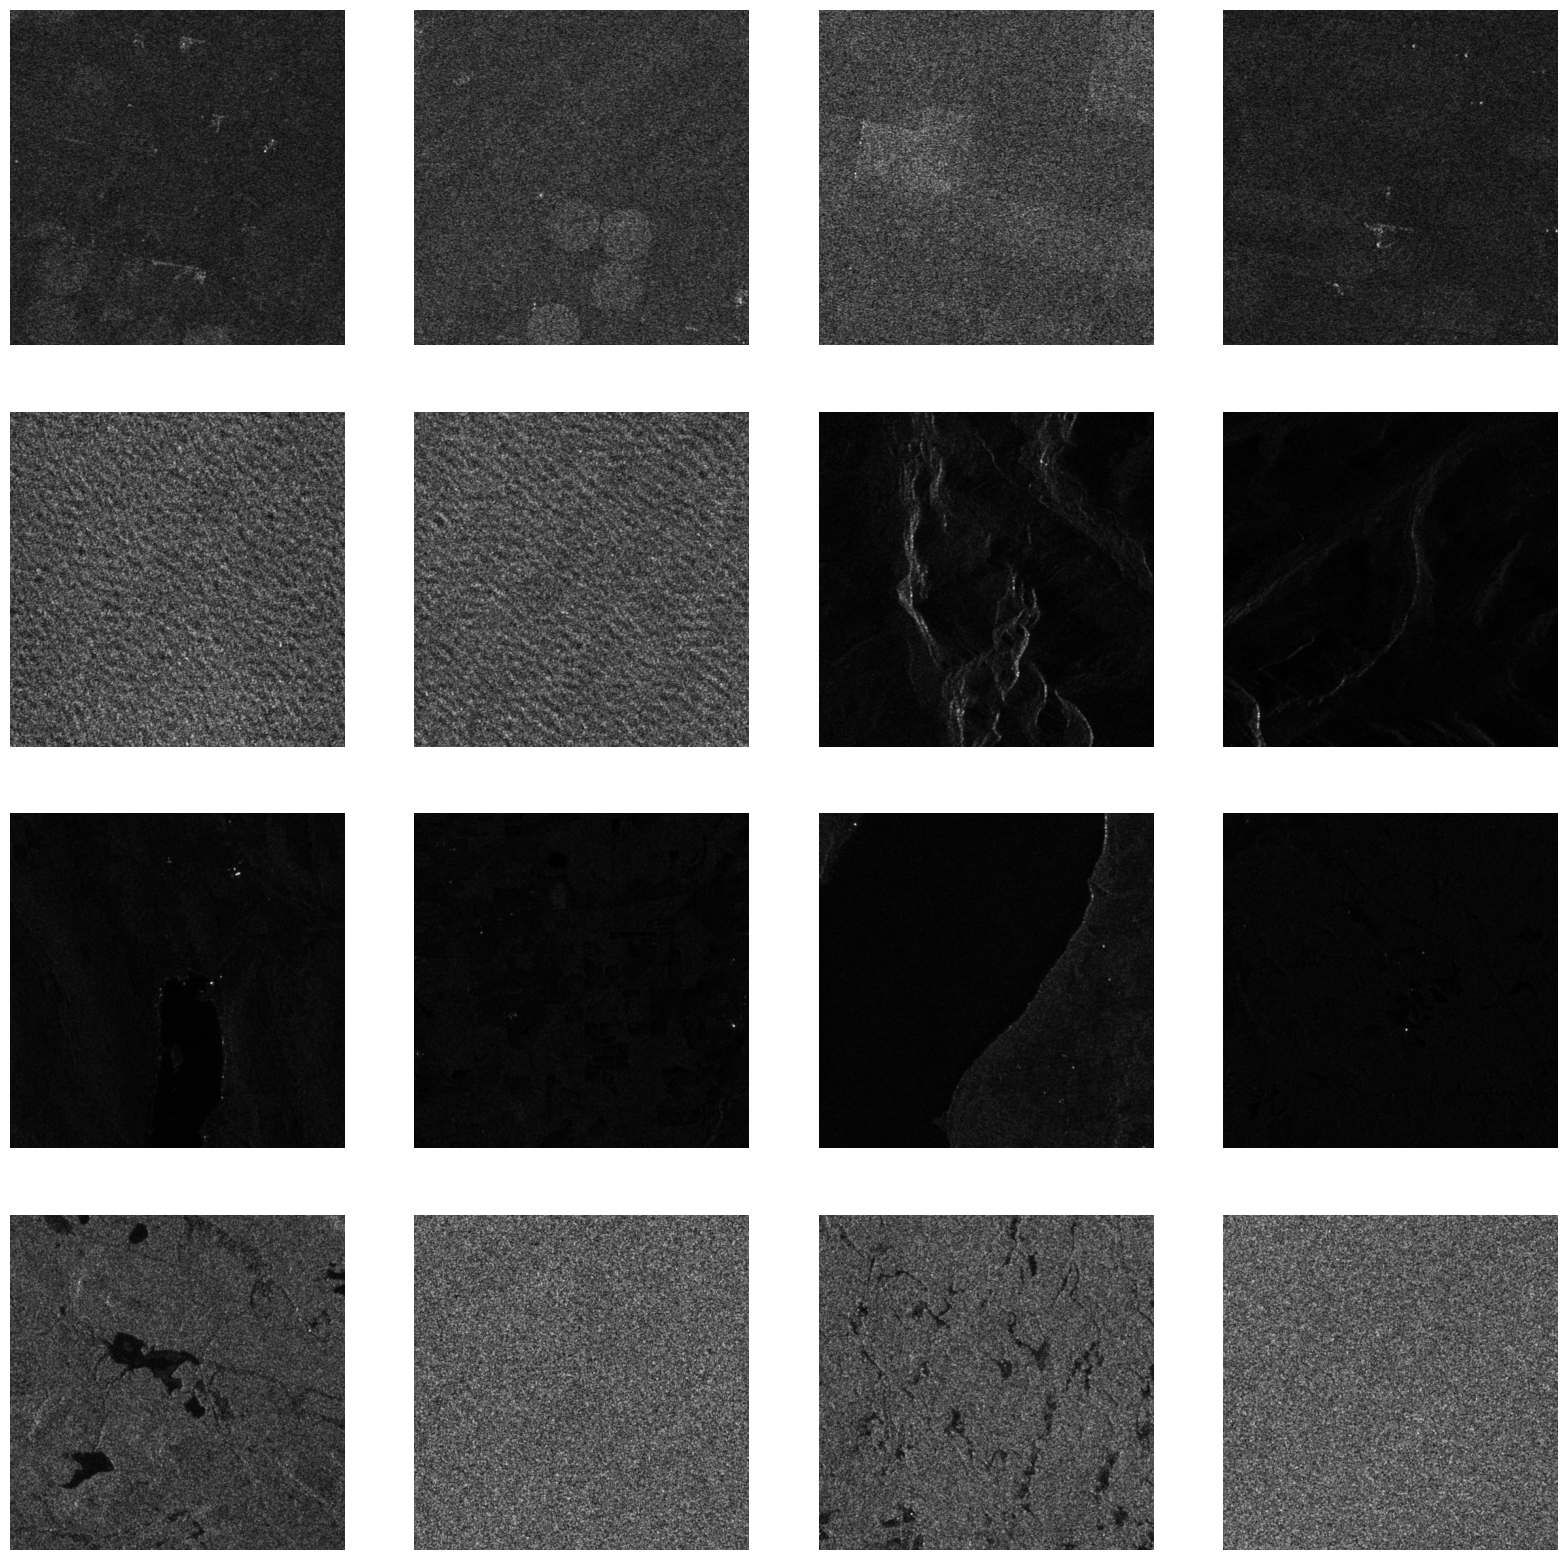

In [7]:
val_batch = next(iter(dataloader))
val_images = val_batch["input"].to(device)

plot_image_batch(val_images)

In [8]:
def run_in_patches(val_images, pipeline, unet_size=64):
    # Split the image into patches
    patches = val_images.unfold(2, unet_size, unet_size).unfold(3, unet_size, unet_size)
    patches = patches.contiguous().view(-1, 1, unet_size, unet_size)

    # Run the pipeline on the patches
    with torch.no_grad():
        patches = pipeline(patches)

    # Reshape the patches back into an image
    patches = patches.view(val_images.size(0), -1, unet_size, unet_size)
    patches = patches.permute(0, 1, 2, 3).contiguous()
    patches = patches.view(val_images.size(0), -1, unet_size * unet_size)

    return patches 

In [9]:
val_images.shape

torch.Size([16, 1, 512, 512])

In [10]:
val_images_uf64 = torch.nn.functional.unfold(val_images, 64, stride=32)
val_images_uf64 = rearrange(val_images_uf64, "b (c h w) p -> p b c h w", c=1, h=64, w=64)

val_images_uf64.shape

torch.Size([225, 16, 1, 64, 64])

## SAR images despeckling with 100 inference steps:

In [13]:
# this runs for a very long time.

# generator = torch.Generator(device=pipeline.device).manual_seed(0)

# denoised_images_uf64_100steps = torch.zeros_like(val_images_uf64) 

# for i in tqdm(range(val_images_uf64.shape[0]), colour="blue", desc="patch"):
#     pipeline.progress_bar = lambda _: _
#     denoised_images_uf64_100steps[i] = pipeline(val_images_uf64[i], generator=generator, num_inference_steps=100, return_tensor=True)


In [14]:
# denoise_images_100steps = torch.nn.functional.fold(rearrange(denoised_images_uf64_100steps, "p b c h w -> b (c h w) p"), output_size=512, kernel_size=64, stride=32)

In [9]:
# torch.save(denoise_images_100steps, '/data/sar/SAR_denoise_images_100steps')
denoise_images_100steps = torch.load('/data/sar/SAR_denoise_images_100steps')

In [ ]:
plot_image_batch(denoise_images_100steps)

## SAR images, 100 inference steps. Left: speckle added, right: despeckled

In [ ]:
valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))
# plot pairs of images next to each other
fig, ax = plt.subplots(len(indices), 2, figsize=(10, len(indices)*5))
for i, idx in enumerate(indices):
    ax[i, 0].imshow(f(val_images[idx]), cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].imshow(f(denoise_images_100steps[idx]), cmap="gray")
    ax[i, 1].axis("off")
    fig.tight_layout()

In [ ]:
### Saving images for the report, image display is off:

valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))
# plot pairs of images next to each other
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, idx in enumerate(indices):
    plt.ioff()
    ax[0].imshow(f(val_images[idx]), cmap="gray")
    ax[0].axis("off")
    ax[1].imshow(f(denoise_images_100steps[idx]), cmap="gray")
    ax[1].axis("off")
    plt.tight_layout()
    plt.savefig('/data/images/sar_despeckling' + str(i) +  '.png', dpi=300)
    
    plt.ion()



## SAR images despeckling with 1000 inference steps:

In [10]:
# This runs for a very long time. The output is saved below.

# generator = torch.Generator(device=pipeline.device).manual_seed(0)

# denoised_images_uf64_1000steps = torch.zeros_like(val_images_uf64) 

# for i in tqdm(range(val_images_uf64.shape[0]), colour="blue", desc="patch"):
#     pipeline.progress_bar = lambda _: _
#     denoised_images_uf64_1000steps[i] = pipeline(val_images_uf64[i], generator=generator, num_inference_steps=1000, return_tensor=True)


In [11]:
# denoise_images_1000steps = torch.nn.functional.fold(rearrange(denoised_images_uf64_1000steps, "p b c h w -> b (c h w) p"), output_size=512, kernel_size=64, stride=32)

In [12]:
# torch.save(denoise_images_1000steps, '/data/sar/SAR_denoise_images_1000steps')
denoise_images_1000steps = torch.load('/data/sar/SAR_denoise_images_1000steps')

In [ ]:
plot_image_batch(denoise_images_1000steps)

## SAR images, 1000 inference steps. Left: speckle added, right: despeckled

In [ ]:
valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))
# plot pairs of images next to each other
fig, ax = plt.subplots(len(indices), 2, figsize=(10, len(indices)*5))
for i, idx in enumerate(indices):
    ax[i, 0].imshow(f(val_images[idx]), cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].imshow(f(denoise_images_1000steps[idx]), cmap="gray")
    ax[i, 1].axis("off")
    plt.tight_layout()


In [ ]:
valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))
# plot pairs of images next to each other
fig, ax = plt.subplots(len(indices), 2, figsize=(20, len(indices)*10))
for i, idx in enumerate(indices):
    ax[i, 0].imshow(f(val_images[idx]), cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].imshow(f(denoise_images_1000steps[idx]), cmap="gray")
    ax[i, 1].axis("off")
    plt.tight_layout()
